# Precision cosmology with Bayesian forward modelling of galaxy surveys
# (2-point statistics v/s $\infty$-point statistics)

This is a project to substantiate the gain in information in AP test from doing a full Bayesian forward modelling approach, relative to a standard analysis restricted to 2-point statistics (i.e. at the level of power spectrum).

Here, we approach the above problem from a different perspective and assess how much information we lose, if we do not employ the full approach at the level of the field, which encodes all the higher-order statistics.

**N.B.:** For submission as MNRAS letter.

### Import relevant packages

In [1]:
%pylab inline
import numpy as np
import tqdm
import scipy as sp
import scipy.constants as spc
from scipy.interpolate import interp1d
from matplotlib import rc
rc('text', usetex=True)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from time import time as wall_time
import seaborn as sns
import astropy as ap
from astropy.constants import c
from astropy.cosmology import FlatwCDM
import itertools
#from numba import njit, prange
from concurrent.futures import ThreadPoolExecutor, as_completed, ProcessPoolExecutor

Populating the interactive namespace from numpy and matplotlib


### Load VELMASS simulation

In [2]:
grid_resolution = 256 #128
box_size_Mpc = 1000 #4000. # Mpc/h

density = np.load("altair_density_1000Mpc.npz")["density"]
δ_ref_com = density.copy()

### Visualize a slice of given thickness of density field (in comoving space)

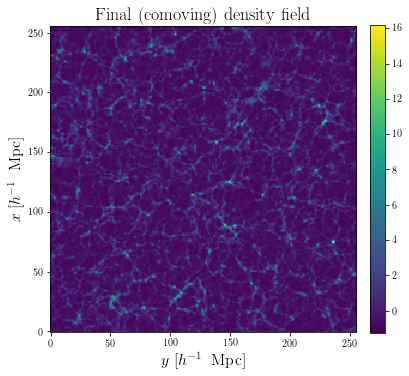

In [3]:
slice_thickness = 128

fig, ax = subplots(1, figsize = (6,8))

#a = ax.imshow(np.sum(np.log(1. + δ_ref_com[:,:,:slice_thickness]), axis=2), origin="lower")#, vmin=0, vmax=60)
a = ax.imshow(δ_ref_com[:,:,64], origin="lower")#, vmin=0, vmax=60)
ax.set_title(r"$\mathrm{Final \ (comoving) \  density \ field}$", fontsize=18)
ax.set_xlabel(r'$y \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16)
ax.set_ylabel(r'$x \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16)
plt.colorbar(a, ax=ax, fraction=0.046, pad=0.04)

### Compute power spectrum, $P(k)$

In [33]:
pred_size = grid_resolution

nbins = 200
lx = np.fft.fftfreq(int(pred_size), d = box_size_Mpc/grid_resolution)[:, None, None] * 2. * np.pi
ly = np.fft.fftfreq(int(pred_size), d = box_size_Mpc/grid_resolution)[None, :, None] * 2. * np.pi
lz = np.fft.fftfreq(int(pred_size), d = box_size_Mpc/grid_resolution)[None, None, :int((pred_size/2)+1)] * 2. * np.pi
l = np.sqrt(lx**2. + ly**2. + lz**2.)
P_w, l_bins = np.histogram(l, bins = nbins)
l_c = 0.5 * (l_bins[0:l_bins.size-1]+l_bins[1:])

def compute_power_spectrum(δ_slice):
    
    a_l_δ = np.fft.rfftn(δ_slice)*(box_size_Mpc/grid_resolution)**3.
    a_l_δ[0,0,0] = 0.
    C_l_δ = 1. / ( (box_size_Mpc/grid_resolution)*pred_size )**3. * np.absolute(a_l_δ)**2.

    P_δ, l_bins = histogram(l, weights = C_l_δ, bins = nbins)
    P_δ /= P_w
    
    return P_δ

Pk_δ_ref_com = compute_power_spectrum(δ_ref_com)

## Construct forward model (comoving-redshift space transformation + triquintic interpolation)

### Some physical constants & box/interpolation specs

In [5]:
# Some physical constants (useful for units)
H100 = 100. # km/s/Mpc
M_IN_KM = 1000. # number of metres in one kilometre
cosmo_clight = c.value # speed of light in m/s
cosmo_clight2 = spc.speed_of_light # speed of light in m/s
Qfactor = (H100*M_IN_KM)/cosmo_clight # Q has units h100/Mpc
cosmo = FlatwCDM(H0=67.75, Om0=0.3089, w0=-1)

# 3D interpolation specs
#n_order = 2 # Trilinear interpolation
#n_order = 4 # Tricubic interpolation
n_order = 6 # Triquintic interpolation
x_inter = np.zeros(n_order, dtype='int')

# Box specs
N0 = pred_size
N1 = pred_size
N2 = pred_size
pred_size_Mpc = 1000 #4000

### Specify comoving box

In [6]:
L0 = pred_size_Mpc
L1 = pred_size_Mpc
L2 = pred_size_Mpc

corner_c_0 = -pred_size_Mpc/2
corner_c_1 = -pred_size_Mpc/2
corner_c_2 = -pred_size_Mpc/2

# The box is shifted by some redshift z_min (chosen value)
z_min = 4000

delta_c_0 = L0/N0
delta_c_1 = L1/N1
delta_c_2 = L2/N2

### Computing redshift for comoving distance (given a cosmology)

In [7]:
# Convert comoving distance to redshift
# This requires inverse of a complicated function. Quicker way is to do a tabulated function and interpolate
# Input: z [dimensionless], Output: comoving distance [Mpc]

def interp_comov2z(cosmo):
    
    z_range = np.linspace(0, 10000*Qfactor, 15000)  # Choice a redshift range (dimensionless)
    comoving_distance = cosmo.comoving_distance(z_range)*(cosmo.H0.value/100)
    comoving2z = interp1d(comoving_distance.value, z_range, bounds_error=False)
    
    return comoving2z

comoving2z = interp_comov2z(cosmo)

### Build redshift box

In [8]:
L_z_0 = L0
L_z_1 = L1
L_z_2 = comoving2z(L2)/Qfactor # Divide by Qfactor to get cosmological redshift in units of [Mpc/h]

corner_z_0 = 0
corner_z_1 = 0
corner_z_2 = -z_min #-L_z_2

delta_z_0 = L_z_0/N0
delta_z_1 = L_z_1/N1
delta_z_2 = L_z_2/N2

### Build matrix of interpolation coefficients (and its inverse)

In [9]:
def prepareMatrix(interpolation="Triquintic"):
    
    M_matrix = np.zeros([n_order**3,n_order**3], dtype='float') # matrix of interpolation coefficients
    
    # Declare variables required for trilinear/tricubic/triquintic interpolation
    if interpolation == "Trilinear":
        x_inter = [0,1]
    
    if interpolation == "Tricubic":    
        x_inter = [-1,0,1,2]
    
    if interpolation == "Triquintic":    
        x_inter = [-2,-1,0,1,2,3]

    # Construct the M_matrix that encodes the interpolation coefficients
    for (alpha,beta,gamma) in itertools.product(range(n_order),range(n_order),range(n_order)):
        for (i,j,k) in itertools.product(range(n_order),range(n_order),range(n_order)):
            M_matrix[n_order**2*alpha + n_order*beta + gamma,n_order**2*i + n_order*j + k] = (x_inter[alpha]**i)*(x_inter[beta]**j)*(x_inter[gamma]**k)

    # Compute the inverse of M_matrix
    M_inverse = np.linalg.inv(M_matrix)

    return M_matrix, M_inverse

M_matrix, M_inverse = prepareMatrix() # Compute M_matrix only once

### Visualize matrix of interpolation coefficients

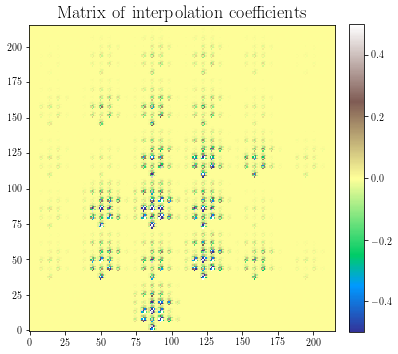

In [10]:
fig, ax = subplots(1, figsize = (6,8))

a = ax.imshow(M_inverse[:,:], vmin=-0.5, vmax=0.5, cmap="terrain", origin="lower")
ax.set_title(r"$\mathrm{Matrix \ of \ interpolation \ coefficients}$", fontsize=18)
plt.colorbar(a, ax=ax, fraction=0.046, pad=0.04)

### Update coordinate system (for a given cosmology)

In [11]:
#@njit(parallel=True)
def update_coordinate_system(Omega_m=0.3089, w_0=-1):
    
    grid_transform = np.zeros([N0,N1,N2,4])

    # Load cosmology using astropy
    cosmo = FlatwCDM(H0=67.75, Om0=Omega_m, w0=w_0)
    # Update accordingly
    comoving2z = interp_comov2z(cosmo)

    for n0 in tqdm.tqdm(range(N0)):
        for n1 in range(N1):
            for n2 in range(N2):                
                c_x = (n0*delta_c_0) + corner_c_0
                c_y = (n1*delta_c_1) + corner_c_1
                c_z = (n2*delta_c_2) + corner_c_2

                # {z_x, z_y, z_z} in Mpc/h
                #denominator = comoving2z(z_min)/(1 + z_min*Qfactor) # dimensionless
                d_A = (cosmo.comoving_distance(z_min*Qfactor).value*(cosmo.H0.value/H100)) / (1 + z_min) # dimensionless

                z_x = c_x/d_A
                z_y = c_y/d_A
                z_z = comoving2z(c_z + z_min)/Qfactor
                z_r = np.sqrt(z_x**2 + z_y**2 + z_z**2)
                r_c = cosmo.comoving_distance(z_r*Qfactor).value*(cosmo.H0.value/H100) # z_r*Qfactor = adimensional;r_c has units Mpc/h100

                if r_c == 0:
                    c_x = 0.
                    c_y = 0.
                    c_z = 0.

                # Shift z_z back (subtract z_min) ### FIXME
                ###z_z -= comoving2z(z_min)/Qfactor
                ###z_r = np.sqrt(z_x**2 + z_y**2 + z_z**2)
                
                E_z = cosmo.H(z_r*Qfactor)/(cosmo.H0.value) # E_z is dimensionless
                del_z_del_x = E_z.value
                Jc = del_z_del_x - (z_r/r_c)

                # Compute all 9 components of (3x3) matrix J for each voxel
                J_00 = ( (Jc*c_x*c_x)/(r_c*r_c) ) + (z_r/r_c)
                J_01 = ( (Jc*c_x*c_y)/(r_c*r_c) )
                J_02 = ( (Jc*c_x*c_z)/(r_c*r_c) )
                J_10 = J_01 # Symmetric about leading diagonal
                J_11 = ( (Jc*c_y*c_y)/(r_c*r_c) ) + (z_r/r_c)
                J_12 = ( (Jc*c_y*c_z)/(r_c*r_c) )
                J_20 = J_02
                J_21 = J_12
                J_22 = ( (Jc*c_z*c_z)/(r_c*r_c) ) + (z_r/r_c)
                
                # Compute determinant of (3x3) matrix J -> Jacobian(voxel)
                Jacobian = J_00*(J_11*J_22 - J_12*J_21) - J_01*(J_10*J_22 - J_12*J_20) + J_02*(J_10*J_21 - J_11*J_20)

                grid_transform[n0,n1,n2,0] = (c_x - corner_c_0)/delta_c_0
                grid_transform[n0,n1,n2,1] = (c_y - corner_c_1)/delta_c_1
                grid_transform[n0,n1,n2,2] = (c_z - corner_c_2)/delta_c_2
                grid_transform[n0,n1,n2,3] = 1.0/Jacobian

                if r_c == 0:
                    grid_transform[n0,n1,n2,3] = 1.

                if Jacobian <= 0:
                    assert (Jacobian >= 0), ("Jacobian issue")
                       
                # The following assertions ensure we do not go outside of box
                assert (grid_transform[n0,n1,n2,0] >= 0), ("Underflow lower bound 0")
                assert (grid_transform[n0,n1,n2,0] < (N0)), ("Overflow lower bound 0")
                assert (grid_transform[n0,n1,n2,1] >= 0), ("Underflow lower bound 1")
                assert (grid_transform[n0,n1,n2,1] < (N1)), ("Overflow lower bound 1")
                assert (grid_transform[n0,n1,n2,2] >= 0), ("Underflow lower bound 2")
                assert (grid_transform[n0,n1,n2,2] < (N2)), ("Overflow lower bound 2")

    return grid_transform

### Generic 3D interpolation routine ($n^{\mathrm{th}}$ order)

In [12]:
#@njit(parallel=True)
def interpolate_3d(s_field, grid_transform):
    
    interp_coeff = np.zeros([n_order**3], dtype='float')
    
    # vector that encodes values of (n_order**3) voxels that will contribute to interpolated value
    rho = np.zeros([n_order**3], dtype='float')
    z_field = np.zeros([N0,N1,N2], dtype='float')

    for n0 in tqdm.tqdm(range(N0)):
        for n1 in range(N1):
            for n2 in range(N2):
    
                t = grid_transform[n0,n1,n2]
                out = 0.
            
                ix = int(np.floor(t[0])) # input x-coordinate
                iy = int(np.floor(t[1])) # input y-coordinate
                iz = int(np.floor(t[2])) # input z-coordinate

                rx = t[0] - ix
                ry = t[1] - iy
                rz = t[2] - iz
    
                # Construct rho to evaluate store the value of s_field at all vertices of interest ->
                # vector of dimension n_order**3
                # We use periodic BC here -> Add N0/N1/N2 to prevent negative values
                for alpha in range(n_order):
                    r_alpha = int((ix + x_inter[alpha] + N0) % N0)
                    for beta in range(n_order):
                        r_beta = int((iy + x_inter[beta] + N1) % N1)
                        for gamma in range(n_order): 
                            r_gamma = int((iz + x_inter[gamma] + N2) % N2)
                            rho[n_order**2*alpha + n_order*beta + gamma] = s_field[r_alpha,r_beta,r_gamma]
                            
                # Construct interp_coeff via matricial operation -> vector of dimension n_order**3
                for m in range(n_order**3):
                    #interp_coeff[m] = M_inverse[m,0]*rho[m] + M_inverse[m,1]*rho[m] + M_inverse[m,1]*rho[m] ### For Numba
                    interp_coeff[m] = (M_inverse[m,:]*rho[:]).sum()

                # Core of generic nth order interpolation
                ax = np.zeros([n_order])
                ay = np.zeros([n_order])
                az = np.zeros([n_order])

                for i_tilde in range(n_order):
                    ax[i_tilde] = rx**i_tilde
                    ay[i_tilde] = ry**i_tilde
                    az[i_tilde] = rz**i_tilde
                
                for (i_tilde,j_tilde,k_tilde) in itertools.product(range(n_order),range(n_order),range(n_order)):
                    out += interp_coeff[n_order**2*i_tilde + n_order*j_tilde + k_tilde]*ax[i_tilde]*ay[j_tilde]*az[k_tilde]

                # Since interpolation on delta and not rho
                z_field[n0,n1,n2] = t[3]*(1 + out) - 1
                if z_field[n0,n1,n2] < -1:
                    print(z_field[n0,n1,n2])

                #assert (z_field[n0,n1,n2] > -1), ("z_field not positive")
                
    return z_field

### Compute the ground truth: $\delta_{\mathrm{z}}^{\mathrm{ref}}$ and $P_k^{\mathrm{ref}}$

In [ ]:
grid_transform_ref = update_coordinate_system(Omega_m=0.3089, w_0=-1)

δ_ref_z = interpolate_3d(δ_ref_com, grid_transform_ref)

Pk_δ_ref = compute_power_spectrum(δ_ref_z)

### Compute 2D correlation function

In [52]:
#a_l_δ_z = np.fft.rfftn(δ_ref_z)*(pred_size_Mpc/pred_size)**3.

#C_s = ( (1/pred_size_Mpc)**3.*np.fft.irfftn(np.absolute(a_l_δ_z)**2.) ).flatten()

a_l_δ_z = np.fft.rfftn(δ_ref_z)*((L_z_0*L_z_1*L_z_2)/pred_size**3.)

C_s = ( 1/(L_z_0*L_z_1*L_z_2)*np.fft.irfftn(np.absolute(a_l_δ_z)**2.) ).flatten()

Nbins = 100

xx = np.fft.fftshift(((np.arange(pred_size)/pred_size)*L_z_0) - 0.5*L_z_0)
yy = np.fft.fftshift(((np.arange(pred_size)/pred_size)*L_z_1) - 0.5*L_z_1)
zz = np.fft.fftshift(((np.arange(pred_size)/pred_size)*L_z_2) - 0.5*L_z_2)

s_x = xx[:,None,None].repeat(pred_size,axis=1).repeat(pred_size,axis=2)
s_y = yy[None,:,None].repeat(pred_size,axis=0).repeat(pred_size,axis=2)
s_z = zz[None,None,:].repeat(pred_size,axis=0).repeat(pred_size,axis=1)

s_para = (np.abs(s_z)).flatten()
s_ortho = (np.sqrt(s_x**2 + s_y**2)).flatten()

s_square = s_para**2 + s_ortho**2

corr_2d, x_bins, y_bins = np.histogram2d(s_para, s_ortho, weights=C_s, bins=Nbins)
corr_2d_, _, _ = np.histogram2d(s_para, s_ortho, bins=Nbins)

x_bins_ = 0.5 * (x_bins[0:x_bins.size-1]+x_bins[1:])
y_bins_ = 0.5 * (y_bins[0:y_bins.size-1]+y_bins[1:])

C_ortho_para = corr_2d/corr_2d_

NameError: name 'δ_ref_z' is not defined

In [21]:
a_l_δ_com = np.fft.rfftn(δ_ref_com)*(pred_size_Mpc/pred_size)**3.

C_s = ( (1/pred_size_Mpc)**3.*np.fft.irfftn(np.absolute(a_l_δ_com)**2.) ).flatten()

Nbins = 50

xx = np.fft.fftshift(((np.arange(pred_size)/pred_size)*L0) - 0.5*L0)
yy = np.fft.fftshift(((np.arange(pred_size)/pred_size)*L1) - 0.5*L1)
zz = np.fft.fftshift(((np.arange(pred_size)/pred_size)*L2) - 0.5*L2)

s_x = xx[:,None,None].repeat(pred_size,axis=1).repeat(pred_size,axis=2)
s_y = yy[None,:,None].repeat(pred_size,axis=0).repeat(pred_size,axis=2)
s_z = zz[None,None,:].repeat(pred_size,axis=0).repeat(pred_size,axis=1)

s_para = (np.abs(s_z)).flatten()
s_ortho = (np.sqrt(s_x**2 + s_y**2)).flatten()

s_square = s_para**2 + s_ortho**2

corr_2d, x_bins, y_bins = np.histogram2d(s_para, s_ortho, weights=C_s, bins=Nbins)
corr_2d_, _, _ = np.histogram2d(s_para, s_ortho, bins=Nbins)

x_bins_ = 0.5 * (x_bins[0:x_bins.size-1]+x_bins[1:])
y_bins_ = 0.5 * (y_bins[0:y_bins.size-1]+y_bins[1:])

C_ortho_para = corr_2d/corr_2d_

### Visualize 2D correlation function

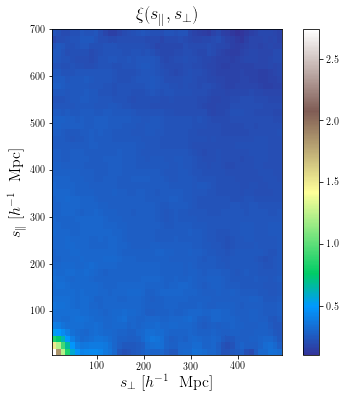

In [31]:
xy = np.meshgrid(x_bins_, y_bins_, indexing='ij')

s_square_bin = xy[0]**2 + xy[1]**2

fig, ax = subplots(1, figsize = (6,6))

#a = ax.pcolormesh(xy[0], xy[1], C_ortho_para*s_square_bin)
a = ax.pcolormesh(xy[0], xy[1], np.log(C_ortho_para), cmap="terrain")
#a = ax.pcolormesh(xy[0], xy[1], np.log(s_square_bin))
#ax.set_title(r"$\mathrm{s^2} \xi(s_{\parallel}, s_{\perp})$", fontsize=18)
ax.set_title(r"$\xi(s_{\parallel}, s_{\perp})$", fontsize=18)
ax.set_xlabel(r'$s_{\perp} \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16)
ax.set_ylabel(r'$s_{\parallel} \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16)
ax.set_aspect('equal')
plt.colorbar(a, ax=ax, fraction=0.05, pad=0.06)

### Compute 1D autocorrelation function

In [15]:
a_l_δ_com = np.fft.rfftn(δ_ref_com)*(pred_size_Mpc/pred_size)**3.

C_s = ( (1/pred_size_Mpc)**3.*np.fft.irfftn(np.absolute(a_l_δ_com)**2.) )

Nbins = 100

xx = np.fft.fftshift(((np.arange(pred_size)/pred_size)*L0) - 0.5*L0)
yy = np.fft.fftshift(((np.arange(pred_size)/pred_size)*L1) - 0.5*L1)
zz = np.fft.fftshift(((np.arange(pred_size)/pred_size)*L2) - 0.5*L2)

s_x = xx[:,None,None].repeat(pred_size,axis=1).repeat(pred_size,axis=2)
s_y = yy[None,:,None].repeat(pred_size,axis=0).repeat(pred_size,axis=2)
s_z = zz[None,None,:].repeat(pred_size,axis=0).repeat(pred_size,axis=1)

x = np.sqrt(s_x**2 + s_y**2 + s_z**2)

corr_1d_w, x_bins = np.histogram(x, bins=Nbins)
corr_1d, _ = np.histogram(x, weights=C_s, bins=Nbins)

corr_1d /= corr_1d_w

x_c = 0.5 * (x_bins[0:x_bins.size-1]+x_bins[1:])

### Visualize 1D autocorrelation function

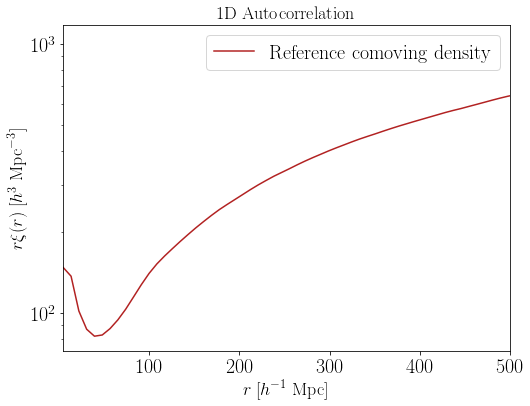

In [23]:
figure(figsize = (8, 6))

plot(x_c, corr_1d*x_c**1, color='firebrick', label=r'$\mathrm{Reference \ comoving \ density}$')

#xscale('log')
yscale('log')
title(r'$\mathrm{1D \ Autocorrelation}$', fontsize = 18)
xlabel(r'$r \; [h^{-1} \; \mathrm{Mpc}]$', fontsize = 18)
ylabel(r'$r \xi(r) \; [h^3 \; {\mathrm{Mpc}}^{-3}]$', fontsize = 18)
xlim([np.min(x_c), L0/2])#np.max(x_c)])
tick_params(labelsize = 20)
legend(fontsize = 20);

### Visualize jacobian of comoving-redshift transformation

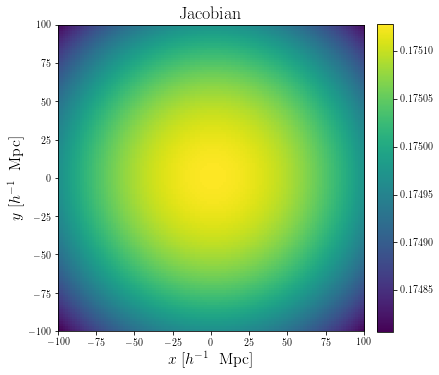

In [27]:
fig, ax = subplots(1, figsize = (6,8))

a = ax.imshow(grid_transform_ref[:,:,-1,3], origin="lower", extent=(-pred_size_Mpc/2,pred_size_Mpc/2,-pred_size_Mpc/2,pred_size_Mpc/2))#, vmin=0.8, vmax=1)
ax.set_title(r"$\mathrm{Jacobian}$", fontsize=18)
ax.set_xlabel(r'$x \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16)
ax.set_ylabel(r'$y \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16)
plt.colorbar(a, ax=ax, fraction=0.046, pad=0.04)

### Visualize comoving vs redshift-space representations of evolved density field

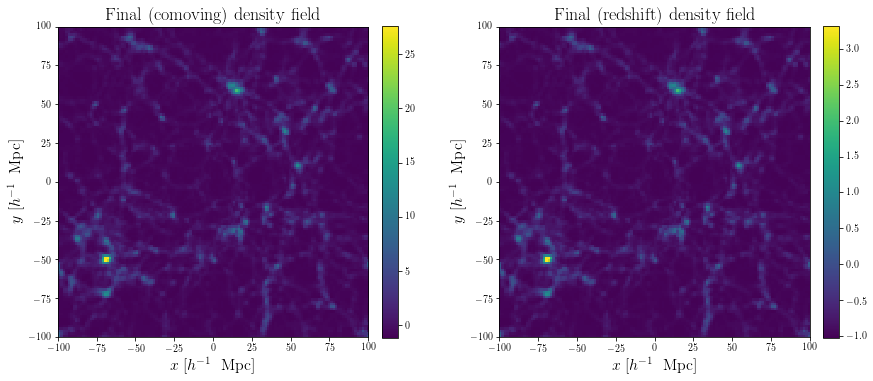

In [31]:
fig, ax = subplots(1, 2, figsize = (14,8))
subplots_adjust(wspace = 0.3, hspace = 0.0)

#a = ax[0].imshow(np.log(1 + δ_ref_com[:,:,int(pred_size/4)]), origin="lower", vmin=-3.5, vmax=0, extent=(-pred_size_Mpc/2,pred_size_Mpc/2,-pred_size_Mpc/2,pred_size_Mpc/2))
#b = ax[1].imshow(np.log(1 + δ_ref_z[:,:,int(pred_size/4)]), origin="lower", vmin=-3.5, vmax=0, extent=(-pred_size_Mpc/2,pred_size_Mpc/2,-pred_size_Mpc/2,pred_size_Mpc/2))

a = ax[0].imshow(δ_ref_com[:,:,-1], origin="lower", extent=(-pred_size_Mpc/2,pred_size_Mpc/2,-pred_size_Mpc/2,pred_size_Mpc/2))
b = ax[1].imshow(δ_ref_z[:,:,-1], origin="lower", extent=(-pred_size_Mpc/2,pred_size_Mpc/2,-pred_size_Mpc/2,pred_size_Mpc/2))
ax[0].set_title(r"$\mathrm{Final \ (comoving) \  density \ field}$", fontsize=18)
ax[0].set_xlabel(r'$x \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16)
ax[0].set_ylabel(r'$y \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16)
ax[1].set_title(r"$\mathrm{Final \ (redshift) \  density \ field}$", fontsize=18)
ax[1].set_xlabel(r'$x \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16)
ax[1].set_ylabel(r'$y \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16)
plt.colorbar(a, ax=ax[0], fraction=0.046, pad=0.04)
plt.colorbar(b, ax=ax[1], fraction=0.046, pad=0.04)

### Visualize power spectra (comoving vs redshift-space representations of evolved density field)

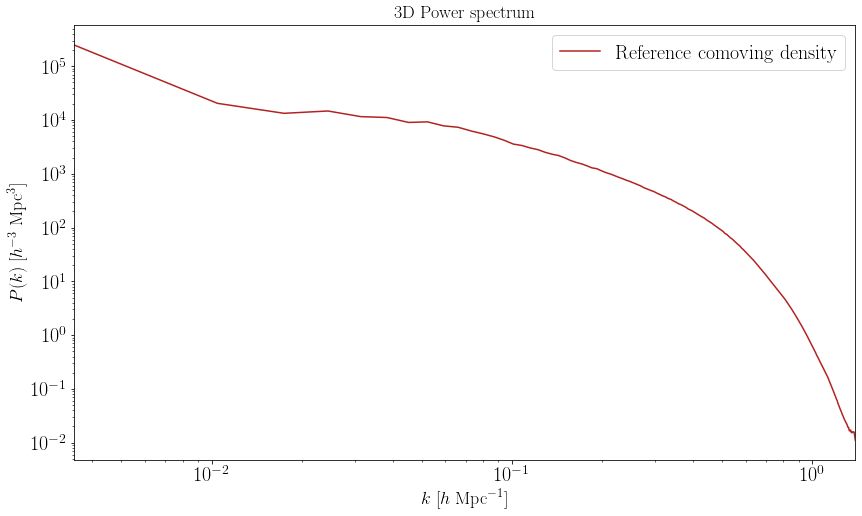

In [34]:
figure(figsize = (14, 8))

#plot(l_c, Pk_δ_mean, color='firebrick', label=r'$\mathrm{Reference \ high-res \ density}$')
#fill_between(l_c, Pk_δ_mean - Pk_δ_std, Pk_δ_mean + Pk_δ_std, facecolor="firebrick", edgecolor="darkslategrey", lw=0.75, alpha=0.55)

plot(l_c, Pk_δ_ref_com, color='firebrick', label=r'$\mathrm{Reference \ comoving \ density}$')
#plot(l_c, Pk_δ_ref, color='midnightblue', label=r'$\mathrm{Reference \ redshift \ density}$')

xscale('log')
yscale('log')
title(r'$\mathrm{3D \ Power \ spectrum}$', fontsize = 18)
xlabel(r'$k \; [h \; {\mathrm{Mpc}}^{-1}]$', fontsize = 18)
ylabel(r'$P(k) \; [h^{-3} \; {\mathrm{Mpc}}^{3}]$', fontsize = 18)
xlim([np.min(l_c), np.max(l_c)])
tick_params(labelsize = 20)
legend(fontsize = 20);

### Choose range of values for $\Omega_{\mathrm{m}}$ and $w_0$

In [ ]:
Nvalues = 25

Omega_m_list = np.linspace(0.15, 0.55, Nvalues)
w_0_list = np.linspace(-1.20, -0.8, Nvalues)

### Cosmological exploration

In [ ]:
def cosmo_main_loop(i,j):
    
    likelihood_Pk = np.zeros((Nvalues,Nvalues))
    likelihood_inf = np.zeros((Nvalues,Nvalues))
    
    theta_omega_m = Omega_m_list[i]
    theta_w_0 = w_0_list[j]
    
    grid_transform_i = update_coordinate_system(Omega_m=theta_omega_m, w_0=theta_w_0)
    δ_z_i = interpolate_3d(δ_ref_com, grid_transform_i)

    likelihood_Pk[i,j] = ((compute_power_spectrum(δ_z_i) - Pk_δ_ref)**2).sum()
    likelihood_inf[i,j] = ((δ_z_i - δ_ref_z)**2).sum()   
    
    return likelihood_Pk, likelihood_inf

executor = ProcessPoolExecutor(max_workers=4)
results = [executor.submit(cosmo_main_loop, i, j) for (i,j) in itertools.product(range(Nvalues),range(Nvalues))]

likelihood_Pk = np.zeros((Nvalues,Nvalues))
likelihood_inf = np.zeros((Nvalues,Nvalues))

for r in range(len(results)):
    likelihood_Pk += results[r].result()[0]
    likelihood_inf += results[r].result()[1]

In [ ]:
likelihood_grid = np.load("likelihood_grid_50.npz")

likelihood_Pk = likelihood_grid["likelihood_Pk"]
likelihood_inf = likelihood_grid["likelihood_inf"]

Nvalues = 50
Omega_m_list = np.linspace(0.15, 0.55, Nvalues)
w_0_list = np.linspace(-1.20, -0.8, Nvalues)
true_omega_m = 0.3089
true_w_0 = -1

In [ ]:
fig, ax = subplots(1, 2, figsize = (12,16))
subplots_adjust(wspace = 0.3, hspace = 0.0)

a = ax[0].imshow(-likelihood_Pk/likelihood_Pk.max(), origin="lower", extent=(Omega_m_list[0], Omega_m_list[-1], w_0_list[0], w_0_list[-1]), aspect="equal", interpolation="nearest", cmap="viridis_r", vmin=-1, vmax=0)
ax[0].set_title(r"$\mathrm{Likelihood} \; P(k)$", fontsize=18)
ax[0].scatter(true_omega_m, true_w_0, marker='*', s=100, color='gold', label=r'$\mathrm{true}$');
#ax.set_xlabel(r'$x \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16)
#ax.set_ylabel(r'$y \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16)
ax[0].set_xlabel(r'$\Omega_{\mathrm{m}}$', fontsize=16);
ax[0].set_ylabel(r'$w_0$', fontsize=16);
plt.colorbar(a, ax=ax[0], fraction=0.046, pad=0.04)

b = ax[1].imshow(-likelihood_inf/likelihood_inf.max(), origin="lower", extent=(Omega_m_list[0], Omega_m_list[-1], w_0_list[0], w_0_list[-1]), aspect="equal", interpolation="nearest", cmap="viridis_r", vmin=-1, vmax=0)
ax[1].set_title(r"$\mathrm{Likelihood \; per \; voxel}$", fontsize=18)
ax[1].scatter(true_omega_m, true_w_0, marker='*', s=100, color='gold', label=r'$\mathrm{true}$');
ax[1].set_xlabel(r'$\Omega_{\mathrm{m}}$', fontsize=16);
ax[1].set_ylabel(r'$w_0$', fontsize=16);
#ax.set_xlabel(r'$x \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16)
#ax.set_ylabel(r'$y \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16)
plt.colorbar(b, ax=ax[1], fraction=0.046, pad=0.04)

## List of tasks:

1) Compute and save $\delta_{\mathrm{z}}^{\mathrm{ref}}$ as `.npz`, which is the redshift-space representation of the central sim.

2) Use $\delta_{\mathrm{z}}^{\mathrm{ref}}$ to compute and save $P_k^{\mathrm{ref}}$ as `.npz`, which is the template reference power spectrum $P(k)$, for a given binning.

3) Build $\mathrm{main}$ function $\rightarrow$ loop over range of $\Omega_{\mathrm{m}}$ and $w_0$ (1 nested loop).

4) $\mathrm{main}$ function should take in central sim (both comoving & redshift), i.e. $\delta_{\mathrm{com}}^{\mathrm{ref}}$ and $\delta_{\mathrm{z}}^{\mathrm{ref}}$, and $P_k^{\mathrm{ref}}$, loop over cosmo params, then save the corresponding likelihood values only (keep overwriting density and power spectrum arrays) in a list, i.e. $\mathcal{L}_{(2)}$ and $\mathcal{L}_{(\infty)}$.

5) [TODO] Implement *remote observer approximation* ($z_r = z_z$, $c_0 = 0$, $c_1 = 0$, $c_2 = \mathrm{position \ of \ observer}$).

6) [TODO] Use Pylians to compute 2-point correlation function, which will replace all power spectrum computations above **OR** try 2d correlation plot

7) Use `seaborn` to plot joint and marginal likelihood distributions.